In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('full_zno.csv')

/var/folders/3d/h6nvvzgn4n30qgsfd1vh5pyc0000gn/T/ipykernel_74619/2343335949.py:1: DtypeWarning: Columns (17,20,23,26,29,32,35,38,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('full_zno.csv')


1. Анализ по отдельным переменным
   1.1 Годы
   1.2 Профиль участника
   1.3 География
   1.4 Предметы
2. Комбинированный анализ
   2.1 Профиль + Годы
   2.2 География + Годы
   2.3 Предметы + Годы
   2.4 Профиль + Предметы
4. Общие выводы и ключевые инсайты
5. Визуализации и дашборды

# Аналіз по окремих змінних | Analysis by individual variables

## 1.1 Роки | Years | Годы

Шаблон анализа:
Количество участников по годам
- participants_by_year, 
- participants_by_year_plot

Процент неявок по годам
- noshow_by_year

Средний / медианный балл по годам 
- by_year, 
- mean_median_by_year_plot

Стандартное отклонение 
- by_year_score_std
- by_year_score_std_plot

% высокобалльников / низкобалльников
- high_low_failed_by_year
- high_low_failed_by_year_plot


Динамика по годам: рост / падение количества участников, среднего балла, процента неявок +
- partic_count_by_year_dynamic
- avg_score_dynamic
- no_show_rate_by_year

### Кількість учасників за роками та частка кожного року у загальному масиві | Number of participants by year and share of each year in the total dataset 

In [3]:
participants_count = df.groupby('Year')['Id'].count().sort_index()

In [4]:
participants_percent = (df['Year'].value_counts(normalize=True).sort_index() * 100).round(2)

In [5]:
participants_by_year = pd.concat([participants_count, participants_percent], axis=1) \
                        .reset_index().rename(columns={'Id':'count',
                                                       'proportion': '%_of_total'})

In [6]:
participants_by_year

,Year,count,%_of_total
0,2016,268003,8.59
1,2017,240889,7.72
2,2018,335687,10.76
3,2019,353813,11.34
4,2020,379299,12.16
5,2021,389323,12.48
6,2022,234104,7.50
7,2023,288935,9.26
8,2024,312508,10.02
9,2025,317091,10.16


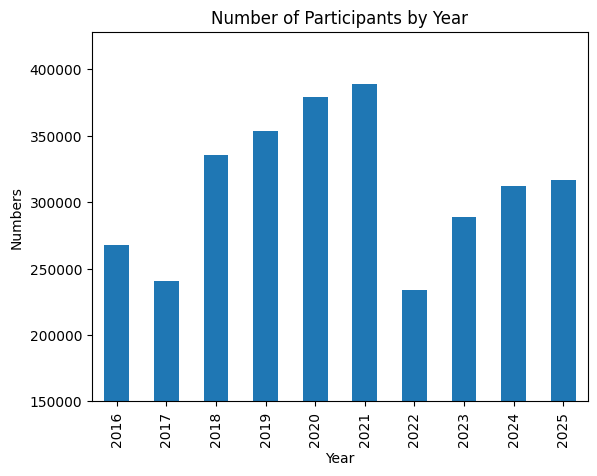

In [7]:
fig, ax1 = plt.subplots()

participants_count.plot(kind='bar', ax=ax1)
ax1.set_ylabel('Numbers')
ax1.set_ylim(150000, participants_count.max() * 1.1)
ax1.set_title('Number of Participants by Year')

participants_by_year_plot = fig

Укр:
Чітко простежується зростання кількості учасників з 2016 по 2021 рік. Різке зниження у 2022 році пояснюється початком повномасштабної війни. З 2023 року спостерігається поступове відновлення активності. Порівняння 2024 і 2025 років показує практично однакову кількість учасників. Особливо цікаво буде побачити дані за 2026 рік, щоб оцінити подальший тренд з урахуванням поточної ситуації в країні

Eng:
There is a clear increase in the number of participants from 2016 to 2021. The sharp decline in 2022 is explained by the start of the full-scale war. Since 2023, a gradual recovery in activity has been observed. A comparison of 2024 and 2025 shows almost the same number of participants. It will be especially interesting to see the data for 2026 to assess the future trend given the current situation in the country.

### Відсоток неявок за роками | Percentage of no-shows by year | Процент неявок по годам

In [8]:
prefs = ('Ukr', 'Math', 'Hist', 'Eng', 'Fra', 'Deu', 'Spa', 'Phys', 'Chem', 'Bio', 'Geo', 'UkrLit')

In [9]:
df['statuses_comb'] = df[[pref + 'Status' for pref in prefs]] \
        .apply(lambda x: set(x) - {'Не складав'}, axis=1)

збираю статуси по всіх предметах в одну множину, щоб визначити відсоток учасників
за комбінацією статусів.

In [10]:
statuses_comb = df['statuses_comb'].value_counts().reset_index()

In [11]:
statuses_comb['statuses_comb'] = statuses_comb['statuses_comb'].apply(lambda x: ', '.join(x))

In [12]:
statuses_comb.iloc[7, 0] = 'Не складав'

In [13]:
statuses_comb['%_of_total'] = (statuses_comb['count'] / len(df) * 100).round(2)

Логіка така:

Зараховано — учасник подолав поріг з усіх предметів, у яких брав участь.
Не зараховано — учасник не подолав поріг ні з одного предмета.

Зараховано, Не зараховано — мінімум 1 предмет склав і мінімум 1 предмет не склав.

Не з’явився або анульовано — учасник не з’явився на жоден зареєстрований тест.

Зараховано, Не з’явився або анульовано — мінімум 1 предмет склав, мінімум на 1 предмет не з’явився.

Не зараховано, Не з’явився або анульовано — мінімум 1 предмет не склав, мінімум на 1 предмет не з’явився.

Зараховано, Не зараховано, Не з’явився або анульовано — мінімум 1 склав, мінімум 1 не склав, мінімум 1 не з’явився.

Не складав — невелика кількість учасників, які не складали. 

Але чому тоді вони є в ДФ? 
Усе тому, що насправді ці учасники складали тести, але відмовилися переводити бали в систему 100–200.
Тому для них статус «Не складав».


In [14]:
statuses_comb #за все года

,statuses_comb,count,%_of_total
0,Зараховано,2086792,66.89
1,"Зараховано, Не зараховано",460583,14.76
2,Не з'явився або анульовано,316739,10.15
3,"Зараховано, Не з'явився або анульовано",122769,3.94
4,Не зараховано,85555,2.74
5,"Зараховано, Не зараховано, Не з'явився або ану...",34212,1.10
6,"Не зараховано, Не з'явився або анульовано",10591,0.34
7,Не складав,2411,0.08


In [15]:
df['statuses_comb'] = df['statuses_comb'].apply(lambda x: ', '.join(x))

In [16]:
no_show_by_year = df[df['statuses_comb'] == "Не з'явився або анульовано"].groupby('Year')['Id'].count().reset_index()

In [17]:
total_by_year = df['Year'].value_counts().reset_index()

In [18]:
no_show_by_year_and_total = no_show_by_year.merge(total_by_year, on='Year').rename(columns={'Id':'no_show', 'count':'total_count'})

In [19]:
no_show_by_year_and_total['%no_show_of_total'] = no_show_by_year_and_total['no_show'] / no_show_by_year_and_total['total_count'] * 100

In [20]:
no_show_by_year_and_total['%no_show_of_total'] = no_show_by_year_and_total['%no_show_of_total'].round(1)

In [21]:
total_tests = df[[pref + 'Status' for pref in prefs] + ['Year']]

In [22]:
total_tests["Не з'явився"] = (total_tests[[pref + 'Status' for pref in prefs]] == "Не з'явився або анульовано").sum(axis=1)

/var/folders/3d/h6nvvzgn4n30qgsfd1vh5pyc0000gn/T/ipykernel_74619/1167212966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_tests["Не з'явився"] = (total_tests[[pref + 'Status' for pref in prefs]] == "Не з'явився або анульовано").sum(axis=1)


In [23]:
total_tests['count_reg_tests'] = (total_tests[[pref + 'Status' for pref in prefs]] != "Не складав").sum(axis=1)

/var/folders/3d/h6nvvzgn4n30qgsfd1vh5pyc0000gn/T/ipykernel_74619/2243426049.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_tests['count_reg_tests'] = (total_tests[[pref + 'Status' for pref in prefs]] != "Не складав").sum(axis=1)


In [24]:
total_tests = total_tests.groupby('Year')[["Не з'явився", "count_reg_tests"]].sum().reset_index()

In [25]:
total_tests['%_of_total'] = (total_tests["Не з'явився"] / total_tests["count_reg_tests"] * 100).round(2)

In [26]:
noshow_by_year = no_show_by_year_and_total.merge(total_tests, on='Year')[['Year', 
                                                         'total_count', 'no_show', '%no_show_of_total',
                                                         'count_reg_tests', "Не з'явився", '%_of_total']]

In [27]:
old_names = list(noshow_by_year.columns)
new_names = ['Year', 'Num_of_Particip', 'Missed_All', 'Missed_All_Perc', 
             'Reg_Tests', 'Missed_Tests', 'Missed_Tests_Perc']
noshow_by_year = noshow_by_year.rename(columns=dict(zip(old_names, new_names)))

In [28]:
noshow_by_year

,Year,Num_of_Particip,Missed_All,Missed_All_Perc,Reg_Tests,Missed_Tests,Missed_Tests_Perc
0,2016,268003,12546,4.7,876061,66650,7.61
1,2017,240889,9563,4.0,836836,50723,6.06
2,2018,335687,9383,2.8,914011,46700,5.11
3,2019,353813,8952,2.5,1041699,45531,4.37
4,2020,379299,94707,25.0,1227151,314166,25.60
5,2021,389323,84184,21.6,1700962,388660,22.85
6,2022,234104,20030,8.6,702312,60090,8.56
7,2023,288935,20807,7.2,866805,62421,7.20
8,2024,312508,29138,9.3,1250032,116910,9.35
9,2025,317091,27429,8.7,1268364,109856,8.66


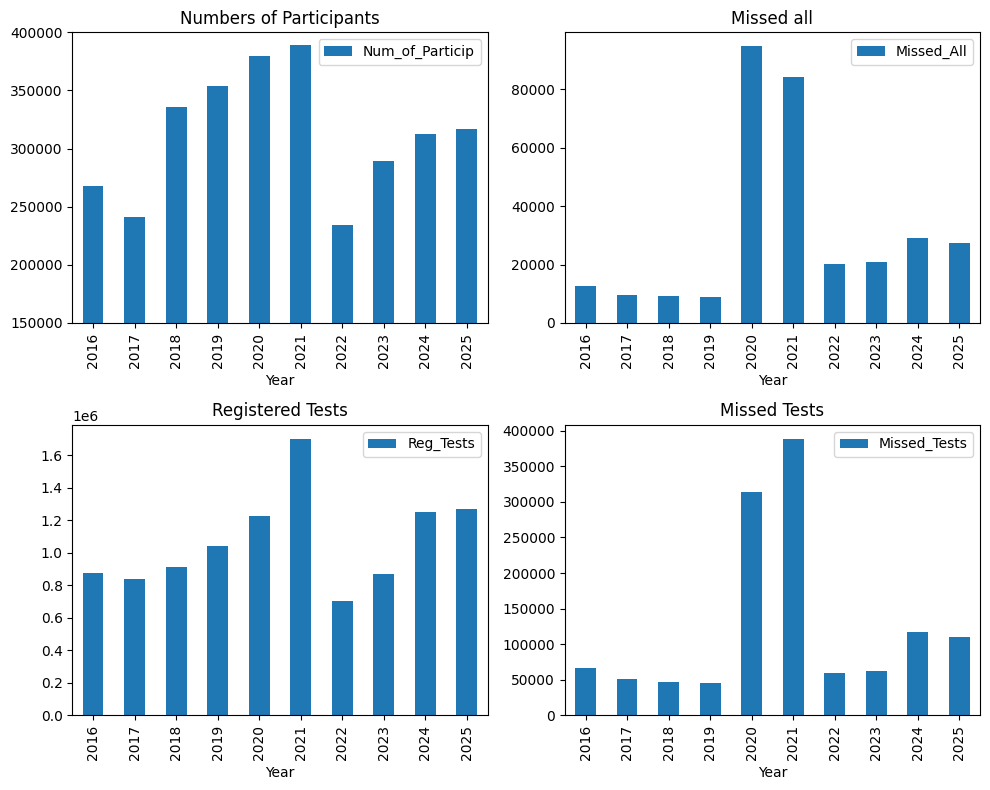

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

noshow_by_year.plot(kind='bar', 
                    x='Year', y='Num_of_Particip', 
                    ylim=(150000, 400000),
                    ax=axes[0, 0], title='Numbers of Participants')
noshow_by_year.plot(kind='bar', x='Year', y='Missed_All', ax=axes[0, 1], title='Missed all')
noshow_by_year.plot(kind='bar', x='Year', y='Reg_Tests', ax=axes[1, 0], title='Registered Tests')
noshow_by_year.plot(kind='bar', x='Year', y='Missed_Tests', ax=axes[1, 1], title='Missed Tests')

plt.tight_layout()


Укр:
(Num_of_Particip, Missed_all, Missed_All_Perc) – кількість учасників, які не з’явилися на жоден із зареєстрованих тестів.
(Reg_Tests, Missed_Tests, Missed_Tests_Perc) – кількість тестів, на які були зареєстровані учасники, та які були пропущені.

Особливо помітно, як у 2020 та 2021 роках цей показник значно зріс. Це пов’язано з пандемією COVID-19 та організаційним хаосом. Тестування кілька разів переносили, змінювали правила, а регіони закривали на локдауни.

Англ:
(Num_of_Particip, Missed_all, Missed_All_Perc) – number of participants who did not attend any of the registered tests.
(Reg_Tests, Missed_Tests, Missed_Tests_Perc) – number of tests participants were registered for but missed.

It is especially noticeable that in 2020 and 2021 this indicator increased significantly. This is due to the COVID-19 pandemic and organizational chaos. Testing was postponed several times, rules were changed, and regions were put under lockdowns.


### Середній / медіанний бал за роками | Average / median score by year

In [30]:
balls = df[[pref + 'Ball' for pref in prefs] + ['Year']]

In [31]:
#cреднее по участнику вкл тех кто не сдал(99)
balls['avg_by_person'] = balls[[pref + 'Ball' for pref in prefs]].mean(axis=1)

/var/folders/3d/h6nvvzgn4n30qgsfd1vh5pyc0000gn/T/ipykernel_74619/1740008123.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balls['avg_by_person'] = balls[[pref + 'Ball' for pref in prefs]].mean(axis=1)


In [32]:
balls['avg_by_passed_person'] = balls[[pref + 'Ball' for pref in prefs]].replace(99, np.nan).mean(axis=1)

/var/folders/3d/h6nvvzgn4n30qgsfd1vh5pyc0000gn/T/ipykernel_74619/2217575131.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balls['avg_by_passed_person'] = balls[[pref + 'Ball' for pref in prefs]].replace(99, np.nan).mean(axis=1)


In [33]:
#cредний балл по годам по всем предметам
mean_ball_by_year = balls.groupby('Year')['avg_by_person'].mean().reset_index()

In [34]:
passed_mean_ball_by_year = balls.groupby('Year')['avg_by_passed_person'].mean().round(1).reset_index()

In [35]:
mean_ball_by_year['avg_by_person'] = mean_ball_by_year['avg_by_person'].round(1)

In [36]:
mean_ball = mean_ball_by_year.merge(passed_mean_ball_by_year)

In [37]:
#медианный балл участника 
balls['median_by_person'] = balls[[pref + 'Ball' for pref in prefs]].median(axis=1)

/var/folders/3d/h6nvvzgn4n30qgsfd1vh5pyc0000gn/T/ipykernel_74619/1946889165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balls['median_by_person'] = balls[[pref + 'Ball' for pref in prefs]].median(axis=1)


In [38]:
balls['median_by_passed_person'] = balls[[pref + 'Ball' for pref in prefs]].replace(99, pd.NA).median(axis=1)

/var/folders/3d/h6nvvzgn4n30qgsfd1vh5pyc0000gn/T/ipykernel_74619/1881592709.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  balls['median_by_passed_person'] = balls[[pref + 'Ball' for pref in prefs]].replace(99, pd.NA).median(axis=1)


In [39]:
passed_median_ball_by_year = balls.groupby('Year')['median_by_passed_person'].median().reset_index()

In [40]:
median_ball_by_year = balls.groupby('Year')['median_by_person'].median().reset_index()

In [41]:
median_ball = median_ball_by_year.merge(passed_median_ball_by_year)

In [42]:
by_year = median_ball.merge(mean_ball, on='Year')

In [43]:
by_year

,Year,median_by_person,median_by_passed_person,avg_by_person,avg_by_passed_person
0,2016,130.5,134.0,133.8,137.2
1,2017,132.5,135.0,135.3,138.2
2,2018,126.0,132.0,130.6,135.6
3,2019,127.0,131.5,131.0,135.4
4,2020,133.0,135.0,135.9,138.2
5,2021,133.0,136.0,135.7,138.7
6,2022,147.0,147.0,151.3,151.4
7,2023,143.0,143.0,142.6,143.1
8,2024,141.0,141.5,140.5,141.8
9,2025,140.5,141.0,139.9,141.1


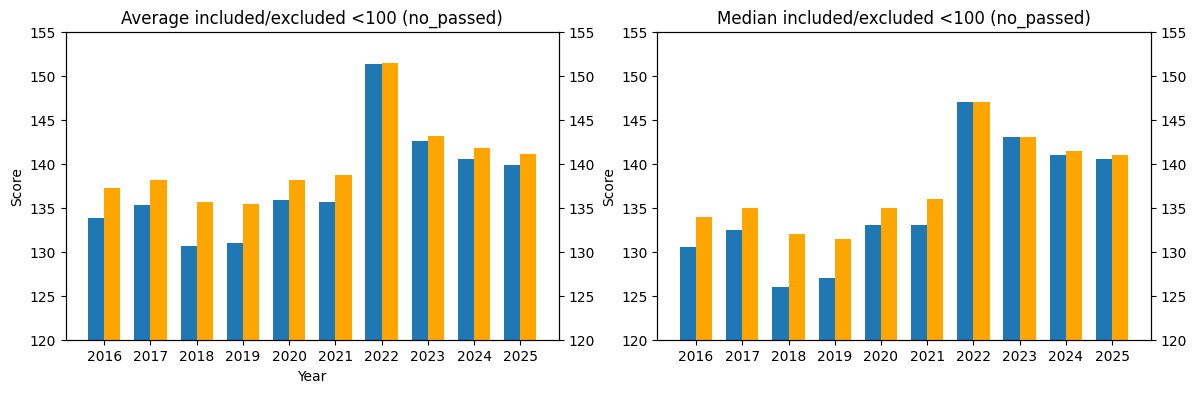

In [44]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
x = np.arange(len(by_year['Year']))
width = 0.35 

ax[0].bar(x - width/2, by_year['avg_by_person'], width=width)
ax[0].set_ylim(120, 155)
ax1 = ax[0].twinx()
ax1.bar(x + width/2, by_year['avg_by_passed_person'], width=width, color='orange')
ax1.set_ylim(120, 155)

ax[1].bar(x - width/2, by_year['median_by_person'], width=width)
ax[1].set_ylim(120, 155)
ax2 = ax[1].twinx()
ax2.bar(x + width/2, by_year['median_by_passed_person'], width=width, color='orange')
ax2.set_ylim(120, 155)

ax[0].set_xticks(x)
ax[0].set_xticklabels(by_year['Year'])
ax[1].set_xticks(x)
ax[1].set_xticklabels(by_year['Year'])

ax[0].set_ylabel('Score')
ax[1].set_ylabel('Score')
ax[0].set_xlabel('Year')
ax[0].set_xlabel('Year')

ax[0].set_title('Average included/excluded <100 (no_passed)')
ax[1].set_title('Median included/excluded <100 (no_passed)')

mean_median_by_year_plot = fig

Укр:
У 2022 році спостерігається різке зростання показників, ймовірно через спрощену форму НМТ у зв’язку з війною. Також видно, що середній бал і медіана з урахуванням учасників, які не склали тест (ball=99), практично не відрізняються від середнього і медіани без урахування тих, що не склали. Це свідчить про те, що майже всі учасники у 2022 році успішно склали тести.

Англ:
In 2022, there is a sharp increase in the indicators, likely due to the simplified form of the NMT because of the war. It is also noticeable that the average score and median including participants who did not pass the test (ball=99) are almost the same as the average and median excluding those who did not pass. This indicates that almost all participants in 2022 successfully passed the tests.

### Стандартне відхилення | Standard deviation | Стандартное отклонение

In [45]:
by_year = by_year.merge(balls.groupby('Year')['avg_by_person'].std().round(2).reset_index(), on='Year')

In [46]:
by_year = by_year.rename(columns={'avg_by_person_y': 'Std'})

In [47]:
balls = balls.rename(columns={'avg_by_person':'avg_all',
                      'median_by_person': 'median_all',
                      'avg_by_passed_person': 'avg_by_passed',
                      'median_by_passed_person': 'median_by_passed'})

In [48]:
new_columns = ['Year', 'median_all', 'median_by_passed', 'avg_all', 'avg_by_passed']
by_year = by_year.rename(columns=dict(zip(list(by_year.columns), new_columns)))
by_year = by_year.merge(balls.groupby('Year')[['avg_all', 'avg_by_passed', 'median_all', 'median_by_passed']] \
    .std().round(2).reset_index(), on='Year', suffixes=('', '_std'))

In [49]:
by_year = by_year[['Year', 'avg_all', 'avg_all_std', 'avg_by_passed', 'avg_by_passed_std', 
                 'median_all', 'median_all_std', 'median_by_passed', 'median_by_passed_std']]

In [50]:
#avg_all_std -- стандартное отклонение среднего балла участника включая тех кто не сдал (99-200)
#avg_by_passed_std -- стандартное отклонение среднего балла участника только тех кто сдал (100-200)
#median_all_std -- стандартное отклонение медианного балла участника включая тех кто не сдал (99-200)
#median_by_passed_std -- стандартное отклонение медианного балла участника только тех кто сдал (100-200)
#STD_mean -- среднее стандартное отклонение среди (avg_all_std, avg_by_passed_std, median_all_std, median_by_passed_std)

by_year_score_std = by_year[['Year', 'avg_all_std', 'avg_by_passed_std', 'median_all_std', 'median_by_passed_std']]
by_year_score_std['STD_mean'] = by_year_score_std[['avg_all_std', 'avg_by_passed_std', 'median_all_std', 'median_by_passed_std']].mean(axis=1).round(2)

/var/folders/3d/h6nvvzgn4n30qgsfd1vh5pyc0000gn/T/ipykernel_74619/1333950431.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  by_year_score_std['STD_mean'] = by_year_score_std[['avg_all_std', 'avg_by_passed_std', 'median_all_std', 'median_by_passed_std']].mean(axis=1).round(2)


In [51]:
by_year_score_std

,Year,avg_all_std,avg_by_passed_std,median_all_std,median_by_passed_std,STD_mean
0,2016,25.09,23.46,26.35,24.55,24.86
1,2017,25.24,23.69,26.75,24.87,25.14
2,2018,25.30,23.47,26.45,24.45,24.92
3,2019,25.24,23.46,26.29,24.35,24.84
4,2020,25.32,24.00,26.62,25.06,25.25
5,2021,25.66,23.99,27.36,25.41,25.60
6,2022,15.80,15.74,16.35,16.27,16.04
7,2023,15.83,15.38,15.62,15.29,15.53
8,2024,15.07,14.18,14.60,13.85,14.42
9,2025,14.61,13.75,14.16,13.44,13.99


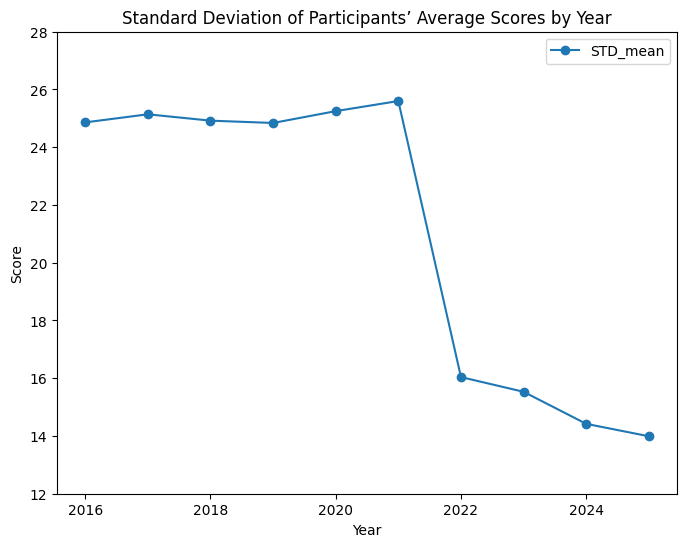

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))
by_year_score_std.plot(x='Year', y='STD_mean', marker='o', ylim=(12, 28), ax=ax)
ax.set_title("Standard Deviation of Participants’ Average Scores by Year")
ax.set_ylabel('Score')

by_year_score_std_plot = fig

Укр: На графіку чітко простежується розмежування між періодами ЗНО та НМТ.
Стандартне відхилення середнього бала учасника зменшилося приблизно з 25 до 16 у 2022 році та продовжує знижуватися в наступні роки. Зменшення стандартного відхилення свідчить про скорочення розкиду результатів — оцінки стають більш однорідними. Це може означати спрощення тесту, зниження його дискримінаційної здатності або більш стандартизовані умови проходження НМТ порівняно із ЗНО. У довгостроковій перспективі це знижує здатність іспиту відрізняти сильних учасників від слабших.

ENG: The chart clearly shows a separation between the ZNO and NMT periods.
The standard deviation of participants’ average scores decreased from approximately 25 to 16 in 2022 and has continued to decline in subsequent years. The decline in standard deviation indicates reduced score dispersion, meaning results have become more homogeneous. This may suggest test simplification, lower discriminatory power, or more standardized testing conditions under NMT compared to ZNO. In the long run, this reduces the exam’s ability to differentiate between stronger and weaker participants.

### % високобалів / низькобалів
Високобалі = >180
Низькобалі = 100–120
Не набрали прохідний бал = 99

% high scorers / low scorers
High scorers = >180
Low scorers = 100–120
Did not reach passing score = 99

% высокобалльников / низкобалльников
Высокобалльники = >180
Низкобалльники = 100–120
Не набрали проходной балл = 99

In [53]:
mask_highscore = (balls['avg_all'] >= 180) | (balls['median_all'] >= 180)
mask_lowscore = (balls['avg_all'].between(100, 120)) | (balls['median_all'].between(100, 120))

In [54]:
'''
фильтрую участников которые получили cредний или медианный балл >180.
Если использовать только среднее, можно пропустить участника, который очень хорошо сдал один предмет, 
а в других немного ниже, — среднее может «разбавить» высокий результат.
Если использовать только медиану, можно пропустить участника с сильными колебаниями: 
например, 200, 180, 100 → медиана 180, среднее ~160.
Комбинированный подход позволяет включить тех, кто либо стабильно высокий (высокая медиана), 
либо у кого есть хотя бы один очень высокий результат (среднее поднимется).
'''
high_ball_persons = balls[mask_highscore]

In [55]:
low_ball_persons = balls[mask_lowscore]

In [56]:
temp = df['Year'].value_counts().reset_index() \
        .merge(high_ball_persons['Year'].value_counts().reset_index(),
         on='Year',
         suffixes=('_total', '_high_ball'))

In [57]:
temp = temp.merge(low_ball_persons['Year'].value_counts().reset_index(), on='Year').rename(columns={'count':'count_low_balls'})

In [58]:
#использую медианну, чтобы найти участников которые провалили тесты так как среднее разбавит результат
# если например участник завалил 3 теста, но сдал только 1. 
temp = temp.merge(balls[(balls['median_all'] == 99)]['Year'] \
    .value_counts().reset_index(), on='Year') \
    .rename(columns={'count':'count_failed'})

In [59]:
temp['%_high_ball'] = (temp['count_high_ball'] / temp['count_total'] * 100).round(1)

In [60]:
temp['%_low_ball'] = (temp['count_low_balls'] / temp['count_total'] * 100).round(1)

In [61]:
temp['%_failed'] = (temp['count_failed'] / temp['count_total'] * 100).round(1)

In [62]:
high_low_failed_by_year = temp[['Year', 'count_total', 
      'count_high_ball', '%_high_ball',
      'count_low_balls', '%_low_ball',
      'count_failed', '%_failed'
      ]].sort_values('Year')

In [63]:
#общая таблица высокобальных/низкобальных, и проваливших тесты.
high_low_failed_by_year

,Year,count_total,count_high_ball,%_high_ball,count_low_balls,%_low_ball,count_failed,%_failed
7,2016,268003,16077,6.0,84647,31.6,16544,6.2
8,2017,240889,16880,7.0,75575,31.4,18311,7.6
3,2018,335687,17911,5.3,106670,31.8,45147,13.4
2,2019,353813,19194,5.4,116826,33.0,36487,10.3
1,2020,379299,21794,5.7,92411,24.4,17015,4.5
0,2021,389323,25465,6.5,98829,25.4,23884,6.1
9,2022,234104,20747,8.9,517,0.2,232,0.1
6,2023,288935,9546,3.3,14524,5.0,408,0.1
5,2024,312508,5850,1.9,17690,5.7,52,0.0
4,2025,317091,4803,1.5,18654,5.9,53,0.0


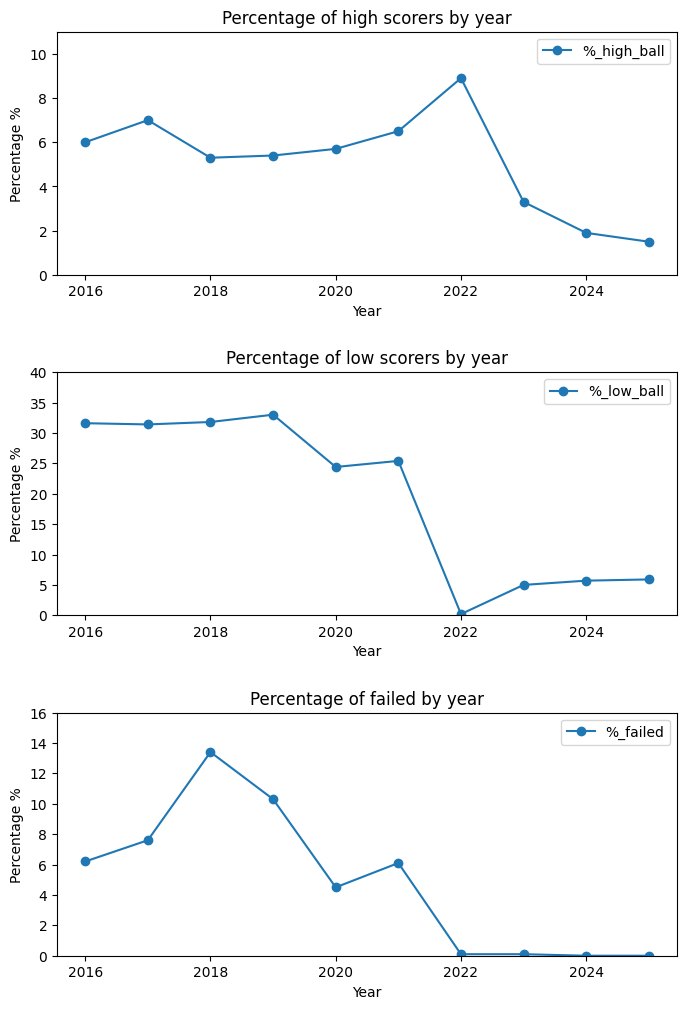

In [64]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
fig.subplots_adjust(hspace=0.4)

high_low_failed_by_year.plot(x='Year', y='%_high_ball', 
                             marker='o', ylim=(0, 11),
                             ax=axes[0])
axes[0].set_title('Percentage of high scorers by year')
axes[0].set_ylabel('Percentage %')

high_low_failed_by_year.plot(x='Year', y='%_low_ball', 
                             marker='o', ylim=(0, 40), ax=axes[1])
axes[1].set_title('Percentage of low scorers by year')
axes[1].set_ylabel('Percentage %')

high_low_failed_by_year.plot(x='Year', y='%_failed', 
                             marker='o', ylim=(0, 16), 
                             ax=axes[2])
axes[2].set_title('Percentage of failed by year')
axes[2].set_ylabel('Percentage %')

high_low_failed_by_year_plot = fig

Укр:
Чітко простежується зниження частки учасників з високими балами, низькими балами та тих, хто повністю не склав тест, починаючи з 2022 року. Це пов’язано із запровадженням нової, спрощеної системи оцінювання. Подальший аналіз із використанням гістограм розподілу дозволить наочно підтвердити ці відмінності.

Eng:
A clear decline in the share of high scorers, low scorers, and participants who completely failed the test is observed starting from 2022. This trend is associated with the introduction of a new simplified scoring system. Further analysis using distribution histograms will visually confirm these differences.

### Динаміка за роками: зростання / падіння кількості учасників, середнього бала, відсотка неявок
### Year-by-year dynamics: increase / decrease in the number of participants, average score, and no-show rate

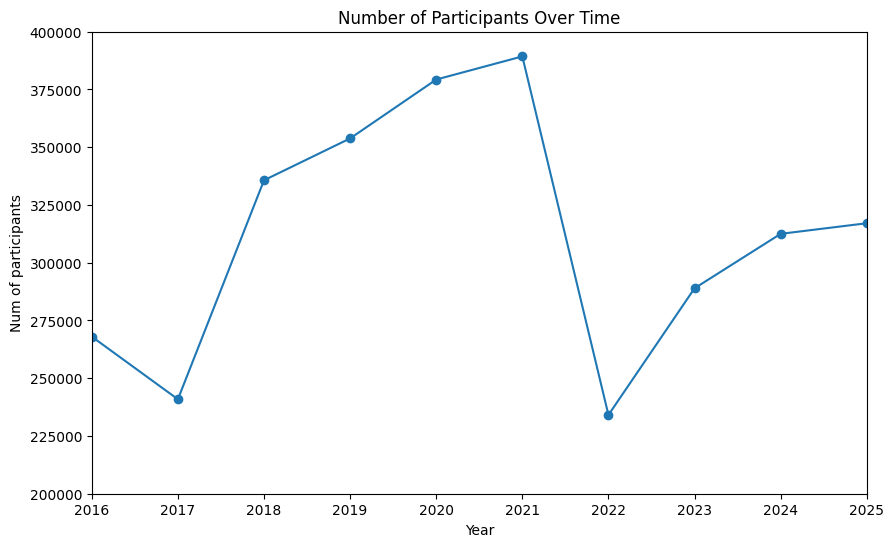

In [65]:
fig, ax = plt.subplots(figsize=(10, 6))

df.groupby('Year')['Id'].count().plot(kind='line', marker='o', ax=ax)
ax.set_ylim(200000, 400000)
ax.set_xlim(2016, 2025)
ax.set_title('Number of Participants Over Time')
ax.set_ylabel('Num of participants')
partic_count_by_year_dynamic = fig

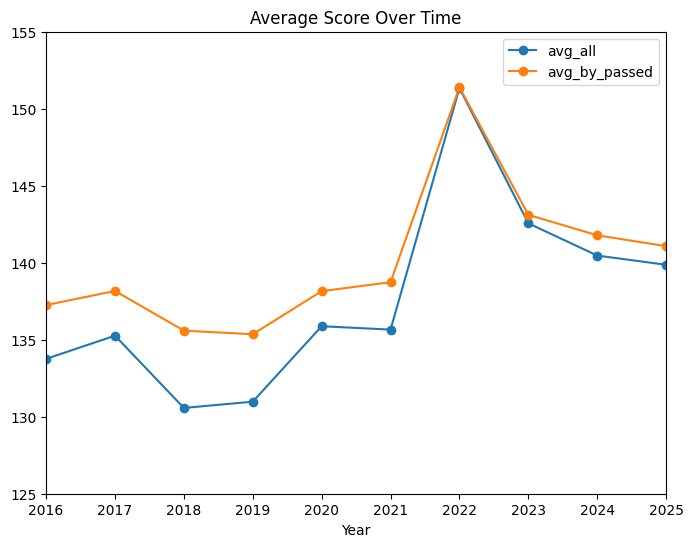

In [66]:
fig, ax = plt.subplots(figsize=(8, 6))

balls.groupby('Year')[['avg_all', 'avg_by_passed']].mean().plot(kind='line', marker='o', ax=ax)
ax.set_ylim(125, 155)
ax.set_xlim(2016, 2025)
ax.set_title('Average Score Over Time')

avg_score_dynamic = fig

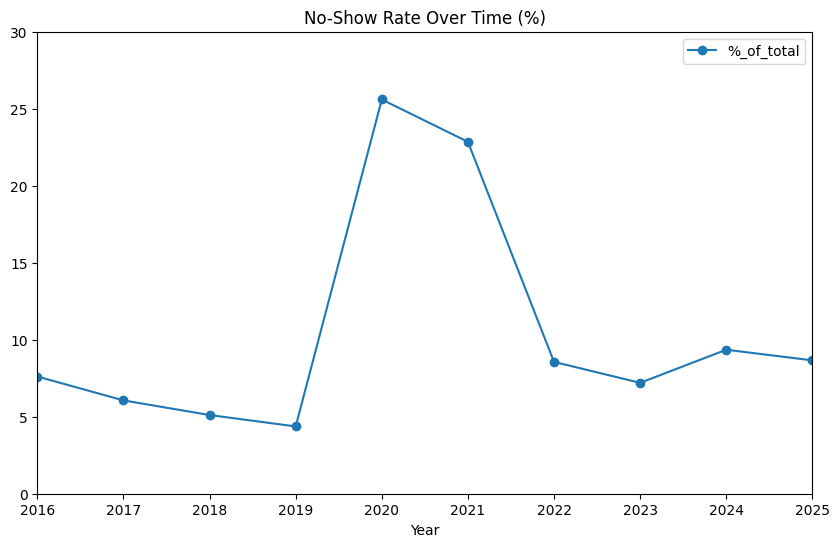

In [67]:
fig, ax = plt.subplots(figsize=(10, 6))

total_tests.plot(x='Year', y='%_of_total', kind='line', marker='o', ax=ax)
ax.set_ylim(0, 30)
ax.set_xlim(2016, 2025)
ax.set_title('No-Show Rate Over Time (%)')

no_show_rate_by_year = fig

## 1.2 Профіль учасника | Participant Profile

Шаблон анализа:
Количество участников по полу 
- count_by_sex

Доля каждой группы в общем массиве 
- count_by_sex
    
Процент неявок по полу 
- perc_missed_tests_by_sex

Средний балл 
- by_participant
    
Медианный балл 
- by_participant
    
Стандартное отклонение 
- by_participant
    
% высокобалльников / низкобалльников 
- by_participant
    
Количество участников по возрасту 
- by_age_group
    
Средний / медианный балл по возрасту 
- by_age_group
    
Анализ выбросов (самые молодые, самые старые)
Top–5 профилей по баллу
Ключевые выводы

In [68]:
by_participant = pd.DataFrame()

### Кількість учасників за статтю та їх частка в загальній сукупності
### Number of Participants by Gender and Share of the Total

In [69]:
count_by_sex = df['Sex'].value_counts(dropna=False).reset_index()

In [70]:
count_by_sex['proportion'] = count_by_sex['count'] / len(df)

In [71]:
by_participant = pd.concat([by_participant, count_by_sex])

In [72]:
by_participant

,Sex,count,proportion
0,жіноча,1578720,0.506056
1,чоловіча,1540932,0.493944


### Відсоток неявок за статтю
### No-Show Rate by Gender

In [73]:
status_by_sex = df.groupby(['Sex', 'statuses_comb'], dropna=False)['Id'] \
    .count().reset_index() \
    .pivot_table(index='statuses_comb', columns='Sex', values='Id')

In [74]:
perc_missed_tests_by_sex = status_by_sex.loc["Не з'явився або анульовано", :] \
    .reset_index().rename(columns={"Не з'явився або анульовано":'missed_all_tests'})

In [75]:
perc_missed_tests_by_sex['%_missed_all_tests'] = ((perc_missed_tests_by_sex['missed_all_tests'] / len(df)) * 100).round(2)

In [76]:
df['count_missed_tests'] = (df.drop('statuses_comb', axis=1) == "Не з'явився або анульовано").sum(axis=1)

In [77]:
df['count_tests'] = (df[[pref + 'Status' for pref in prefs]] != "Не складав").sum(axis=1)

In [78]:
"""змінюємо значення 6 на значення 5.
У 2021 році максимальна кількість тестів, які міг скласти учасник, була 5.
Тоді чому є значення 6?
Справа в тому, що було 2 варіанти тесту: “укр.мова і літ”, “укр.мова”.
Неможливо було складати 2 тести одночасно.
Але для тих, хто складав “укр.мова і літ”,
виділили окреме поле з балом “укр. мова sub_test” на основі тесту “укр.мова і літ”.
Тому логічніше для них прибрати зайвий тест.
"""
df.loc[df['count_tests'] == 6, 'count_tests'] = 5

In [79]:
perc_missed_tests_by_sex = perc_missed_tests_by_sex.merge(df.groupby('Sex')[['count_missed_tests', 'count_tests']] \
    .sum().reset_index())

In [80]:
perc_missed_tests_by_sex['%_missed_tests'] = ((perc_missed_tests_by_sex['count_missed_tests'] / perc_missed_tests_by_sex['count_tests']) * 100).round(2)

In [81]:
by_participant = by_participant.merge(perc_missed_tests_by_sex, on='Sex')

In [82]:
perc_missed_tests_by_sex

,Sex,missed_all_tests,%_missed_all_tests,count_missed_tests,count_tests,%_missed_tests
0,жіноча,135251.0,4.34,559455,5444652,10.28
1,чоловіча,181488.0,5.82,702252,5202475,13.50


### Середній бал, медіанний бал, стандартне відхилення, % високобальників / низькобальників за статтю
### Average Score, Median Score, Standard Deviation, % of High-Scorers / Low-Scorers by Gender

In [83]:
df['avg_ball'] = df[[pref + 'Ball' for pref in prefs]].mean(axis=1)

In [84]:
df['median_ball'] = df[[pref + 'Ball' for pref in prefs]].median(axis=1)

In [85]:
balls_by_sex = df.groupby('Sex')['avg_ball'].agg(avg_ball = 'mean',
                                   median_ball = 'median',
                                   std = 'std').reset_index()

In [86]:
balls_by_sex

,Sex,avg_ball,median_ball,std
0,жіноча,140.274219,139.0,22.533908
1,чоловіча,133.699655,133.0,22.555788


In [87]:
balls_by_sex = balls_by_sex.merge(df[(df['avg_ball'] >= 180) | (df['median_ball'] >= 180)] \
    .groupby('Sex')['Id'] \
    .agg(high_balls='count').reset_index(), on='Sex')

In [88]:
balls_by_sex = balls_by_sex.merge(df[(df['avg_ball'].between(100, 120)) | (df['median_ball'].between(100, 120))] \
    .groupby('Sex')['Id'] \
    .agg(low_balls='count').reset_index(), on='Sex')

In [89]:
by_participant = by_participant.merge(balls_by_sex, on='Sex')

In [90]:
by_participant['%_high_balls_by_sex'] = ((by_participant['high_balls'] / by_participant['count']) * 100).round(2)

In [91]:
by_participant['%_low_balls_by_sex'] = ((by_participant['low_balls'] / by_participant['count']) * 100).round(2)

### Кількість учасників за віком,Середній/медіанний бал за віком
### Number of Participants by Age, Average/Median Score by Age

In [92]:
df['Age'] = df['Year'] - df['Birth']

In [93]:
def age_group(age):
    if 20 <= age <= 24:
        return '20-24'
    elif 25 <= age <= 30:
        return '25-30'
    elif 31 <= age <= 40:
        return '31-40'
    elif 41 <= age <= 50:
        return '41-50'
    elif 51 <= age <= 60:
        return '51-60'
    elif 61 <= age <= 70:
        return '61-70'
    elif 71 <= age :
        return '71+'
    else:
        return str(age)

In [94]:
df['Age_group'] = df['Age'].apply(age_group)

In [95]:
by_age_group = df['Age_group'].value_counts().reset_index()

In [96]:
by_age_group = by_age_group.merge(df.groupby('Age_group')['avg_ball'] \
    .agg(avg_ball='mean', median_ball='median') \
    .reset_index(), on='Age_group')

In [97]:
by_age_group['avg_ball'] = by_age_group['avg_ball'].round(1)

In [98]:
by_age_group['median_ball'] = by_age_group['median_ball'].round(1)

In [99]:
by_age_group

,Age_group,count,avg_ball,median_ball
0,17,1632203,140.0,139.2
1,18,916111,135.6,134.8
2,19,221318,126.3,126.0
3,20-24,185591,130.4,130.5
4,25-30,61977,131.2,131.7
5,31-40,58481,130.7,131.5
6,41-50,22855,134.4,134.5
7,16,17211,140.8,140.2
8,51-60,3606,137.6,136.3
9,15,174,146.3,145.9


### Аналіз викидів (наймолодші, найстарші)
### Outlier Analysis (Youngest and Oldest)

In [100]:
df[df['Age'].between(13, 14)].sort_values('avg_ball', ascending=False)[:4]

,Id,Birth,Sex,RegName,AreaName,TerName,TerTypeName,UkrStatus,Ukr,UkrBall,...,UkrLit,UkrLitBall,Year,statuses_comb,count_missed_tests,count_tests,avg_ball,median_ball,Age,Age_group
2638385,9b904b29-d74a-4a92-822f-75939a851d2b,2010,чоловіча,м.Київ,м.Київ,Подільський район міста,місто,Зараховано,Українська мова,148.0,...,NaN,NaN,2024,Зараховано,0,4,155.250000,151.5,14,14
2174195,29c503b2-628d-4dae-9b4c-fe0e3d32a5e0,2009,чоловіча,Рівненська область,Рівненський район,с.Звіздівка,село,Зараховано,Українська мова,149.0,...,NaN,NaN,2022,Зараховано,0,3,151.666667,150.0,13,13
2010657,d5815bd9-e35e-4241-a09c-486f337a1917,2009,жіноча,м.Київ,м.Київ,Шевченківський район міста,місто,Зараховано,Українська мова,149.0,...,NaN,NaN,2022,Зараховано,0,3,151.000000,149.0,13,13
2194982,39a9038d-e381-465b-b7a3-466c7ae70f66,2008,чоловіча,Одеська область,м.Одеса,Малиновський район міста,місто,Зараховано,Українська мова,154.0,...,NaN,NaN,2022,Зараховано,0,3,150.666667,150.0,14,14


#### Укр: 
У ході аналізу учасників, яким на момент складання тесту було 13–14 років, встановлено, що загальна кількість таких випадків становить лише 12 осіб. Із них високі результати показали лише 4 учасники, що підкреслює винятковість цієї групи. Більшість таких випадків припадає на 2022 рік — період, коли НМТ проводився у спрощеному форматі, що супроводжувалося загальним зміщенням розподілу балів у бік вищих значень.

Водночас, навіть з урахуванням спрощеного формату тестування, ці результати не можна пояснити виключно методичними особливостями НМТ 2022 року. Успішне завершення шкільного навчання та складання національного тестування у такому ранньому віці свідчить про наявність справді виняткових випадках.

Усі четверо учасників набрали близько 150 балів з математики, а один із них продемонстрував надзвичайно високий результат з англійської мови — 191 бал.

#### Eng:
During the analysis of participants aged 13–14 at the time of the test, it was found that there were only 12 such cases. Of these, only 4 participants achieved high scores, highlighting the exceptional nature of this group. Most of these cases occurred in 2022 — a period when the NMT was conducted in a simplified format, which led to a general shift in score distribution towards higher values.

However, even considering the simplified testing format, these results cannot be explained solely by the methodological features of NMT 2022. Successfully completing school and passing the national test at such an early age indicates truly exceptional educational trajectories.
All four participants scored around 150 points in mathematics, and one of them achieved an exceptionally high score in English — 191 points.

In [101]:
df[df['Age'] >= 70].sort_values('avg_ball', ascending=False)[:5]

,Id,Birth,Sex,RegName,AreaName,TerName,TerTypeName,UkrStatus,Ukr,UkrBall,...,UkrLit,UkrLitBall,Year,statuses_comb,count_missed_tests,count_tests,avg_ball,median_ball,Age,Age_group
2499323,9b8f91d3-e532-4bd3-be1d-06bde13a1a67,1954,чоловіча,Інші країни,Німеччина,м.Мюнхен,інша країна,Не зараховано,Українська мова,99.0,...,NaN,NaN,2024,"Зараховано, Не зараховано",0,4,151.250000,158.5,70,61-70
2162800,c3fe83f5-57ff-43ff-a709-c7e63b6399a6,1952,чоловіча,Київська область,Обухівський район,с.Ходосівка,село,Зараховано,Українська мова,135.0,...,NaN,NaN,2022,Зараховано,0,3,139.333333,135.0,70,61-70
3054298,9e64a58c-9f97-4250-9f21-fafe55f2c1e5,1954,чоловіча,Інші країни,Німеччина,м.Мюнхен,інша країна,Не зараховано,Українська мова,99.0,...,NaN,NaN,2025,"Зараховано, Не зараховано",0,4,138.250000,132.5,71,71+
1688850,4e61f33b-89a9-4378-bb46-49666b45f73e,1951,жіноча,Волинська область,Камінь-Каширський район,м.Камінь-Каширський,місто,Зараховано,Українська мова,109.0,...,NaN,NaN,2021,Зараховано,0,1,109.000000,109.0,70,61-70
1219164,4a42e943-6d32-4030-a4e0-bb0222d158af,1944,жіноча,Київська область,Києво-Святошинський район,м.Боярка,місто,Зараховано,Українська мова,100.0,...,NaN,NaN,2020,"Зараховано, Не з'явився або анульовано",1,2,100.000000,100.0,76,71+


Укр:
Також у вибірці виявлено 10 учасників віком понад 70 років. Успішно склали тести лише 5 із них, що свідчить про помітний вплив вікового чинника на результати тестування.

Окремої уваги заслуговує один учасник, який складав тести, перебуваючи в місті Мюнхен. Це чоловік 1954 року народження, який проходив національне тестування два роки поспіль — у 2024 та 2025 роках. В обох спробах він не подолав пороговий бал з української мови, водночас продемонстрував надзвичайно високий рівень підготовки з математики, двічі набравши по 189 балів, що дійсно вражає.

Крім того, учасник складав німецьку мову та показав високі результати: 185 балів у 2024 році та 166 балів у 2025 році. Зниження результату з німецької мови під час другої спроби становить додатковий аналітичний інтерес і може бути пов’язане як зі змінами складності тесту, так і з індивідуальними чинниками (рівень підготовки, формат завдань, умови складання).

Eng:
The sample also included 10 participants over 70 years old. Only 5 of them successfully passed the tests, indicating a noticeable impact of age on test performance.

Of particular interest is one participant who took the tests while in Munich. This man, born in 1954, took the national testing two years in a row — in 2024 and 2025. In both attempts, he did not reach the passing score in Ukrainian, yet demonstrated an exceptionally high level of preparation in mathematics, scoring 189 points twice, which is atypical for this age group.

Additionally, the participant took German and achieved high scores: 185 points in 2024 and 166 points in 2025. The decrease in the German score during the second attempt is of additional analytical interest and may be related both to changes in test difficulty and individual factors (level of preparation, task format, testing conditions).
.

### Топ-профілі за балами | Top Profiles by Score

In [102]:
tb = df[(df['avg_ball'] == 200) & (df['count_tests'] >=3)]

In [103]:
tb.head()

,Id,Birth,Sex,RegName,AreaName,TerName,TerTypeName,UkrStatus,Ukr,UkrBall,...,UkrLit,UkrLitBall,Year,statuses_comb,count_missed_tests,count_tests,avg_ball,median_ball,Age,Age_group
128084,b2eede40-69b2-445c-ad2e-2e9516876587,1992,жіноча,м.Київ,м.Київ,Голосіївський район міста,місто,Зараховано,Українська мова,200.0,...,NaN,NaN,2016,"Зараховано, Не з'явився або анульовано",2,3,200.0,200.0,24,20-24
272917,2AF5A7CE-3969-4225-AEBC-F4D690FD2C77,1997,жіноча,м.Київ,м.Київ,Святошинський район міста,місто,Не з'явився або анульовано,Українська мова,NaN,...,NaN,NaN,2017,"Зараховано, Не з'явився або анульовано",3,4,200.0,200.0,20,20-24
303554,EE73051E-CCA1-40DA-A4EF-03E1719E6EDB,1995,жіноча,м.Київ,м.Київ,Голосіївський район міста,місто,Не з'явився або анульовано,Українська мова,NaN,...,NaN,NaN,2017,"Зараховано, Не з'явився або анульовано",3,4,200.0,200.0,22,20-24
396342,A53C4DAF-3896-4F88-86D2-3309EDCABBCF,1992,жіноча,м.Київ,м.Київ,Шевченківський район міста,місто,Зараховано,Українська мова,200.0,...,NaN,NaN,2017,"Зараховано, Не з'явився або анульовано",2,3,200.0,200.0,25,25-30
540415,fb557ecf-ec2d-4980-bc42-18cb41e5284c,1977,жіноча,Вінницька область,Гайсинський район,м.Гайсин,місто,Не з'явився або анульовано,Українська мова,NaN,...,NaN,NaN,2018,"Зараховано, Не з'явився або анульовано",2,3,200.0,200.0,41,41-50


In [104]:
tb['RegName'].value_counts() # топ участников по областям

RegName
м.Київ                       135
Львівська область            102
Дніпропетровська область      38
Харківська область            32
Волинська область             29
Івано-Франківська область     25
Київська область              24
Вінницька область             23
Одеська область               22
Сумська область               21
Чернігівська область          21
Полтавська область            19
Рівненська область            19
Черкаська область             17
Хмельницька область           16
Тернопільська область         14
Житомирська область           14
Закарпатська область          13
Чернівецька область           12
Донецька область              12
Херсонська область            10
Запорізька область            10
Миколаївська область           7
Кіровоградська область         4
Луганська область              1
Name: count, dtype: int64

In [105]:
tb['Age'].value_counts().reset_index().sort_values('Age') #топ участников по возрасту

,Age,count
6,16,3
0,17,436
1,18,178
2,19,4
7,20,2
5,21,3
9,22,1
4,23,3
3,24,3
8,25,2


In [106]:
tb['Sex'].value_counts() #по полу 

Sex
жіноча      407
чоловіча    233
Name: count, dtype: int64

In [107]:
tb['Year'].value_counts() #по годам

Year
2022    564
2023     50
2024      7
2021      4
2017      3
2019      3
2020      3
2025      3
2018      2
2016      1
Name: count, dtype: int64

Укр:
У ході аналізу учасників, які склали три і більше тестів із середнім результатом близько 200 балів, виявлено низку показових закономірностей. Передусім привертає увагу різкий структурний розрив за роками. До 2022 року середня кількість таких «відмінників» становила приблизно 3 особи на рік і залишалася стабільною протягом тривалого періоду.

У 2022 році цей показник різко зріс до 564 учасників, попри те, що саме на цей рік припадає мінімальна кількість учасників за весь період 2016–2025 років. Така невідповідність між обсягом вибірки та кількістю максимальних результатів свідчить про істотну зміну умов тестування.

Отримані дані дають підстави висунути кілька гіпотез: або тести у 2022 році були значно спрощені, або контроль за процедурою проведення був послаблений. Водночас більш обережна інтерпретація полягає в тому, що тестування зберігало формальну доброчесність, але було адаптоване до кризових умов, що й призвело до аномально високих результатів без прямих ознак системних корупційних механізмів.

Географічний аналіз показує, що більшість учасників із найвищими результатами складали тести в місті Києві та Львівській області. Ймовірно, це пов’язано з тим, що Львівська область у 2022 році прийняла значну кількість учасників із прифронтових регіонів, що буде підтверджено або спростовано на наступних етапах аналізу за регіонами.

Додатково встановлено виражену гендерну різницю: серед учасників із максимальними результатами жінок майже удвічі більше, ніж чоловіків.

Eng:
The analysis of participants who took three or more tests with an average score of around 200 points revealed several notable patterns. First, a sharp structural gap across years is striking. Until 2022, the average number of such “top performers” was approximately 3 people per year and remained stable over a long period.

In 2022, this number surged to 564 participants, despite the fact that this year saw the lowest overall number of participants during 2016–2025. This discrepancy between sample size and the number of maximum scores indicates a significant change in testing conditions.

The data allow for several hypotheses: either the 2022 tests were significantly simplified, or the monitoring of the testing procedure was relaxed. A more cautious interpretation suggests that the testing maintained formal integrity but was adapted to crisis conditions, resulting in anomalously high scores without direct evidence of systemic corruption.

Geographical analysis shows that most participants with the highest scores took the tests in Kyiv and Lviv regions. This is likely because Lviv region in 2022 hosted a significant number of participants from frontline areas, which will be confirmed or refuted in subsequent regional analysis.

Additionally, a pronounced gender difference was observed: among participants with maximum scores, women are almost twice as many as men.


## 1.3 География
Шаблон анализа:
Количество участников по областям 
- by_reg
Доля каждой области в общем массиве
- attend_by_reg_perc
Процент неявок по областям
- attend_by_reg_perc
Средний / медианный балл по областям, Стандартное отклонение, % высокобалльников / низкобалльников
- balls_by_reg
        
Город vs Село:
количество участников, средний балл, процент неявок, разрыв между городом и селом
- city_village

Самая «умная» область (город / село)

Межрегиональная дифференциация (максимум–минимум)
Top–5 / Bottom–5 областей по баллу
Ключевые выводы

In [108]:
by_reg = df['RegName'].value_counts(dropna=False).reset_index()

In [109]:
by_reg['%_of_total'] = (by_reg['count'] / len(df) * 100).round(2)

In [110]:
ns = df[df['statuses_comb'] == "Не з'явився або анульовано"]['RegName'].value_counts(dropna=False).reset_index()

In [111]:
by_reg = by_reg.merge(ns, on='RegName').rename(columns={'count_x': 'count_total',
                                                        'count_y': 'missed_all_tests'})

In [112]:
by_reg['%_missed_all_tests_by_reg'] = (by_reg['missed_all_tests'] / by_reg['count_total'] * 100).round(2)

In [113]:
cms = df.groupby('RegName')[['count_missed_tests', 'count_tests']].sum().reset_index()

In [114]:
cms['%_missed_tests'] = (cms['count_missed_tests'] / cms['count_tests'] * 100).round(2)

In [115]:
by_reg = by_reg.merge(cms, on='RegName')

### Количество участников по областям, Доля каждой области в общем массиве, Процент неявок по областям

In [117]:
attend_by_reg_perc = by_reg[['RegName', '%_of_total', '%_missed_all_tests_by_reg', '%_missed_tests']]

In [118]:
attend_by_reg = by_reg[['RegName', 'count_total', 'missed_all_tests', 'count_tests',  'count_missed_tests']]

In [119]:
attend_by_reg_perc.sort_values('%_missed_all_tests_by_reg', ascending=False)

,RegName,%_of_total,%_missed_all_tests_by_reg,%_missed_tests
25,Інші країни,0.38,31.27,31.37
21,Чернівецька область,2.47,13.06,15.10
15,Закарпатська область,3.28,12.46,13.80
23,Херсонська область,2.05,12.13,14.59
24,Луганська область,1.15,11.87,13.85
9,Запорізька область,3.74,11.77,13.85
14,Донецька область,3.33,11.55,13.58
8,Рівненська область,3.80,11.06,12.61
1,Дніпропетровська область,8.17,11.04,12.40
18,Сумська область,2.72,11.02,13.13


Укр: Найбільша кількість учасників, які взагалі не з’явилися на тестування, становить близько 31%. Ця частка переважно припадає на групу, яка реєструвалася для здачі тестів за кордоном. Високий рівень неявки дозволяє висунути гіпотезу, що учасники у зв’язку з війною в Україні не планували продовжувати навчання в українських закладах освіти. Серед областей із найбільшою неявкою до топ-5 входять Чернівецька, Закарпатська, Херсонська, Луганська та Запорізька області.

Eng: The highest share of participants who did not appear for the test at all is about 31%. This proportion mainly comes from the group that registered to take the exams abroad. The high no-show rate allows us to hypothesize that, due to the war in Ukraine, many participants did not plan to continue their studies at Ukrainian educational institutions. Among the regions with the highest no-show rates, the top five include Chernivtsi, Zakarpattia, Kherson, Luhansk, and Zaporizhzhia regions.

### Средний / медианный балл по областям, Стандартное отклонение, высокобалльников / низкобалльников

In [120]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [121]:
by_reg = by_reg.merge(df.groupby('RegName')['avg_ball'].agg(avg_ball_by_reg='mean',
                                      median_ball_by_reg='median',
                                      std_by_reg = 'std').reset_index(), on='RegName')

In [122]:
by_reg = by_reg.merge(df[(df['avg_ball'] >= 180) | (df['median_ball'] >= 180)].groupby('RegName')['Id'] \
    .agg(count_high_balls='count').reset_index(), on='RegName')

In [123]:
by_reg['%_high_balls_by_reg'] = by_reg['count_high_balls'] / by_reg['count_total'] * 100

In [124]:
by_reg = by_reg.merge(df[(df['avg_ball'].between(100, 120)) | (df['median_ball'].between(100, 120))] \
    .groupby('RegName')['Id'] \
    .agg(count_low_balls='count').reset_index(), on='RegName')

In [125]:
by_reg['%_low_balls_by_reg'] = by_reg['count_low_balls'] / by_reg['count_total'] * 100

In [126]:
balls_by_reg = by_reg[['RegName', 'avg_ball_by_reg', 'median_ball_by_reg', 'std_by_reg', 'count_high_balls',
                      '%_high_balls_by_reg', 'count_low_balls', '%_low_balls_by_reg']]

In [127]:
range_max_min = balls_by_reg['avg_ball_by_reg'].max() - balls_by_reg['avg_ball_by_reg'].min()

In [128]:
range_max_min #Межрегиональная дифференциация (максимум–минимум) 

np.float64(15.641460463704277)

In [131]:
balls_by_reg.sort_values('%_low_balls_by_reg', ascending=False).T

,24,23,15,14,9,19,21,3,22,11,...,12,18,4,5,17,16,13,2,0,25
RegName,Луганська область,Херсонська область,Закарпатська область,Донецька область,Запорізька область,Миколаївська область,Чернівецька область,Одеська область,Кіровоградська область,Житомирська область,...,Хмельницька область,Сумська область,Харківська область,Київська область,Черкаська область,Тернопільська область,Волинська область,Львівська область,м.Київ,Інші країни
avg_ball_by_reg,131.83,132.09,129.33,133.58,134.07,133.00,132.37,134.79,134.70,135.13,...,136.60,136.96,138.72,138.10,137.93,137.29,138.36,142.66,144.97,142.41
median_ball_by_reg,129.00,129.33,128.00,131.75,132.75,132.00,131.50,134.00,134.00,134.25,...,135.80,136.00,137.75,137.25,136.67,136.33,137.67,142.00,144.00,141.33
std_by_reg,23.27,23.54,22.96,23.62,22.67,21.79,23.12,22.21,21.72,21.92,...,21.98,22.18,22.76,21.70,21.23,22.68,22.42,23.73,23.00,13.29
count_high_balls,1304,2562,3172,4527,4658,2620,2817,7262,2620,4276,...,4643,3940,10344,6686,4108,4630,5506,19703,27041,105
%_high_balls_by_reg,3.62,4.01,3.10,4.36,3.99,3.21,3.66,3.72,3.64,3.98,...,4.33,4.65,5.52,4.73,4.51,5.04,5.24,8.51,9.35,0.89
count_low_balls,10476,18551,27390,27312,28693,19631,17946,43811,15665,22889,...,21079,16184,35421,26309,16871,16749,18695,35205,38317,283
%_low_balls_by_reg,29.12,29.07,26.80,26.30,24.60,24.05,23.32,22.46,21.77,21.29,...,19.66,19.10,18.90,18.61,18.54,18.21,17.78,15.20,13.24,2.40


Укр: Аналіз балів за областями показує, що найвищі середні та медіанні показники мають учасники з наступних регіонів: 
місто Київ (145), Львівська область (143), Харківська область (139), Волинська область (138) та Київська область (138). 
Також високі результати демонструють учасники, які складали тести за кордоном (середній бал 142).

Міжрегіональна диференціація становить 15,64 бала, що свідчить про помірний розрив між регіонами з найвищими та найнижчими результатами. Показник вказує на наявність територіальних відмінностей, але без різкої поляризації.

Найбільший відсоток учасників із регіонів, у яких середній бал перевищує 180, також спостерігається серед цих областей:
- м. Київ – 9,35% із 289 328 учасників
- Львівська обл. – 8,51% із 231 571 учасника
- Харківська обл. – 5,52% із 187 367 учасників
- Волинська обл. – 5,24% із 105 153 учасників

Найнижчі середні бали зафіксовані у Миколаївській (133), Чернівецькій (132), Херсонській (132), Луганській (132) та Закарпатській (129) областях. 
Відповідно, найбільший відсоток учасників із регіонів, чий середній бал нижче 120, припадає на ці області:
- Луганська обл. – 29,12% із 35 975 учасників
- Херсонська обл. – 29,07% із 63 812 учасників
- Закарпатська обл. – 26,81% із 102 198 учасників
- Донецька обл. – 26,30% із 103 851 учасника
- Запорізька обл. – 24,60% із 116 630 учасників

Eng: An analysis of scores by region shows that the highest average and median results are observed among participants from the following regions: Kyiv city (145), Lviv region (143), Kharkiv region (139), Volyn region (138), and Kyiv region (138). High performance is also demonstrated by participants who took the tests abroad, with an average score of 142.

Interregional differentiation amounts to 15.64 points, indicating a moderate gap between regions with the highest and lowest results. This suggests the presence of territorial differences, but without sharp polarization.

The highest share of participants with scores above 180 is also concentrated in these regions:
- Kyiv city – 9.35% of 289,328 participants
- Lviv region – 8.51% of 231,571 participants
- Kharkiv region – 5.52% of 187,367 participants
- Volyn region – 5.24% of 105,153 participants

The lowest average scores are recorded in Mykolaiv (133), Chernivtsi (132), Kherson (132), Luhansk (132), and Zakarpattia (129) regions. Accordingly, the largest share of participants with average scores below 120 is observed in these regions:
- Luhansk region – 29.12% of 35,975 participants
- Kherson region – 29.07% of 63,812 participants
- Zakarpattia region – 26.81% of 102,198 participants
- Donetsk region – 26.30% of 103,851 participants
- Zaporizhzhia region – 24.60% of 116,630 participants

Conclusion: regional disparities in performance are evident and align closely with geographic and contextual factors, though the overall gap remains moderate rather than extreme.

### Город vs Село | City vs Village:
- Самая «умная» область (город / село)
- Межрегиональная дифференциация (максимум–минимум)
- Top–5 / Bottom–5 областей по баллу

In [132]:
city_village = df.groupby('TerTypeName', dropna=False)['avg_ball'].agg(count_total = 'count',
                                                                       avg_ball_by_regtype = 'mean',
                                                                       std_by_regtype = 'std')

In [133]:
city_village = city_village.reset_index()

In [134]:
city_village = city_village.merge(df[df['statuses_comb'] == "Не з'явився або анульовано"]['TerTypeName'] \
    .value_counts(dropna=False).reset_index(), on='TerTypeName')

In [135]:
city_village['%_missed_all_tests_by_regtype'] = (city_village['count'] / city_village['count_total'] * 100)

In [136]:
cms = df.groupby('TerTypeName')[['count_missed_tests', 'count_tests']].sum().reset_index()

In [137]:
cms['%_missed_tests'] = cms['count_missed_tests'] / cms['count_tests'] * 100

In [138]:
city_village = city_village.merge(cms, on='TerTypeName')

In [139]:
city_village.insert(2, '%_of_total', value=city_village['count_total'] / city_village['count_total'].sum() * 100)

In [140]:
city_village = city_village.rename(columns={'count':'count_missed_all'})

In [141]:
city_village = city_village.merge(df[(df['avg_ball'] >= 180) | (df['median_ball'] >= 180)] \
    .groupby('TerTypeName')['Id'] \
    .agg(count_high_balls='count').reset_index(), on='TerTypeName')

In [142]:
city_village['%_high_balls_by_regtype'] = city_village['count_high_balls'] / city_village['count_total'] * 100

In [143]:
city_village = city_village.merge(df[(df['avg_ball'].between(100, 120)) | (df['median_ball'].between(100, 120))] \
    .groupby('TerTypeName')['Id'] \
    .agg(count_low_balls='count').reset_index(), on='TerTypeName')

In [144]:
city_village['%_low_balls_by_regtype'] = city_village['count_low_balls'] / city_village['count_total'] * 100

In [145]:
city_village_n = city_village[['TerTypeName', 'count_total', 'avg_ball_by_regtype', 'std_by_regtype', 
                              'count_missed_all', 'count_missed_tests', 'count_tests', 
                               'count_high_balls', 'count_low_balls']]

In [146]:
city_village_perc = city_village[['TerTypeName', '%_of_total', '%_missed_all_tests_by_regtype', '%_missed_tests', 
                              '%_high_balls_by_regtype', '%_low_balls_by_regtype']]

In [147]:
city_village = city_village.set_index('TerTypeName').T

In [148]:
#количество участников, средний балл, разрыв между городом и селом
city_village

TerTypeName,місто,село,інша країна
count_total,2132165.00,660245.00,8092.00
%_of_total,76.14,23.58,0.29
avg_ball_by_regtype,138.92,131.10,142.41
std_by_regtype,22.98,21.13,13.29
count_missed_all,242448.00,70610.00,3681.00
%_missed_all_tests_by_regtype,11.37,10.69,45.49
count_missed_tests,968645.00,279448.00,13614.00
count_tests,8047483.00,2556246.00,43398.00
%_missed_tests,12.04,10.93,31.37
count_high_balls,140644.00,17518.00,105.00


In [149]:
#Самая «умная» область (город / село)

In [150]:
balls_by_reg[['RegName', 'avg_ball_by_reg']].sort_values('avg_ball_by_reg', ascending=False)[:2]

,RegName,avg_ball_by_reg
0,м.Київ,144.97
2,Львівська область,142.66


In [151]:
city_top = df[df['TerTypeName'] == 'місто'] \
    .groupby(['RegName', 'TerName'])['avg_ball'] \
    .agg(['count', 'mean']).sort_values('mean', ascending=False)

In [152]:
city_top[city_top['count'] > 1000].sort_values('mean', ascending=False)[:10]

count   mean
RegName                   TerName                              
Львівська область         м.Миколаїв                1194 150.67
                          м.Трускавець              1235 150.08
Івано-Франківська область м.Долина                  2849 149.31
м.Київ                    Дарницький район міста   29515 147.74
                          Печерський район міста   21416 147.59
Львівська область         м.Яворів                  1876 147.54
                          Залізничний район міста  13527 147.43
                          Сихівський район міста   14939 146.95
м.Київ                    Оболонський район міста  21168 146.80
Львівська область         м.Жидачів                 1004 146.75

In [153]:
village_top = df[df['TerTypeName'] == 'село'] \
    .groupby(['RegName', 'TerName'])['avg_ball'] \
    .agg(['count', 'mean']).sort_values('mean', ascending=False)

In [154]:
village_top['count'].mean() # среднее кол-во уч с села

np.float64(30.148173515981735)

In [155]:
village_top['count'].median() # среднее кол-во уч с села

np.float64(4.0)

In [156]:
village_top[village_top['count'] > 15].sort_values('mean', ascending=False)[:10]

count   mean
RegName                   TerName                                             
Львівська область         с.Миртюки                                 149 160.87
                          с.Дуліби (Грабовецько-Дулібівська)         55 160.27
Сумська область           с.Орлівка                                  21 160.19
Львівська область         смт Меденичі                              106 157.12
Івано-Франківська область с.Угорники                               1040 156.72
Полтавська область        с.Ковалівка                               366 155.64
Івано-Франківська область с.Мала Тур'я (Малотур'янська сільрада)     21 155.32
Львівська область         с.Підбірці                                163 155.10
                          с-ще Липівка                               74 154.70
                          с-ще Меденичі                              44 154.65

Порівняння учасників із міст і сільської місцевості демонструє стійкі та системні відмінності. Частка міських учасників становить 76%, тоді як на села припадає 24%, що відповідає співвідношенню 3:1.

Середній бал учасників із міст суттєво вищий, ніж у сільських — 139 проти 131, що вказує на розрив у рівні підготовки. Водночас показники неявки відрізняються незначно. Повна неявка серед міських учасників становить 11,37%, серед сільських — 11%. Подібна ситуація спостерігається й щодо часткової неявки: 12% у містах проти 11% у селах. Таким чином, різниця в результатах не може бути пояснена фактором відвідуваності. 

Виразний розрив спостерігається у показниках крайніх значень. Частка учасників із середнім балом вище 180 у містах становить 6,60%, тоді як у сільській місцевості — лише 2,65% (співвідношення 2,34:1). Водночас частка учасників із середнім балом нижче 120 у містах значно менша — 19,43% проти 30,33% у селах.

У сукупності ці показники свідчать про те, що рівень освіти та освітнього середовища в містах є помітно вищим, ніж у сільській місцевості.

Для визначення найбільш «розумних» міст із метою підвищення статистичної надійності було застосовано поріг у 1 000 і більше учасників. У топі опинилися два міста Львівської області — Миколаїв і Трускавець (середній бал 150), а також місто Долина Івано-Франківської області (149).

Для відбору найбільш «розумних» сіл використовувався мінімальний поріг у 15 учасників, що обумовлено структурою даних: середня кількість учасників із сіл становить 34 особи, за медіанного значення лише 4. Незважаючи на це обмеження, у топі знову домінує Львівська область.
Село Миртюки (149 учасників) демонструє середній бал 161, село Дуліби (Грабовецько-Дулібівська громада) — 160 при 55 учасниках.

Окремо варто виділити село Угорники Івано-Франківської області, де зафіксовано 1 040 учасників із середнім балом 157, що робить цей населений пункт статистично найбільш надійним і водночас одним із найсильніших серед сільської місцевості.